# Telcommunication Churn Analysis Project

## General Objective

The objective of this project is to examine and forecast customer attrition within Vodafone, a telecommunications company in Ghana. The main objective is to create a reliable model for predicting churn, identifying customers who are at risk of leaving and comprehending the factors that contribute to churn. The dataset is comprised of three sections: the training dataset, the evaluation dataset, and the test dataset.

In [1]:
# Import all the neccessary Libraries

import pandas as pd
import pyodbc
import numpy as np
from sqlalchemy import create_engine
from dotenv import dotenv_values
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
from sklearn.model_selection import GridSearchCV
from dotenv import load_dotenv
from dotenv import dotenv_values
import os
import pickle
import warnings
warnings.filterwarnings('ignore')


LOAD DATASETS

For this project, we will load three datasets from various sources.
1. My SQL server
2. Azubi Onedrive
3. Azubi github repository

In [2]:
# Load environment variables from .env file 
environment_variables = dotenv_values('.env')


# Get the values for the credentials in the '.env' file
database = environment_variables.get("DATABASE")
server = environment_variables.get("SERVER")
username = environment_variables.get("USER")
password = environment_variables.get("PASSWORD")


In [3]:
# Create a connection string
connection_string = f"DRIVER={{SQL Server}};SERVER={server};DATABASE={database};UID={username};PWD={password};MARS_Connection=yes;MinProtocolVersion=TLSv1.2;"

In [4]:
# Use the connect method of the pyodbc library and pass in the connection string.
connection = pyodbc.connect(connection_string)

In [5]:
# First dataset
query = "SELECT * FROM LP2_Telco_churn_first_3000"

data_1 = pd.read_sql(query, connection)

data_1.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,False,True,False,1,False,None,DSL,False,...,False,False,False,False,Month-to-month,True,Electronic check,29.850000,29.850000,False
1,5575-GNVDE,Male,False,False,False,34,True,False,DSL,True,...,True,False,False,False,One year,False,Mailed check,56.950001,1889.500000,False
2,3668-QPYBK,Male,False,False,False,2,True,False,DSL,True,...,False,False,False,False,Month-to-month,True,Mailed check,53.849998,108.150002,True
3,7795-CFOCW,Male,False,False,False,45,False,None,DSL,True,...,True,True,False,False,One year,False,Bank transfer (automatic),42.299999,1840.750000,False
4,9237-HQITU,Female,False,False,False,2,True,False,Fiber optic,False,...,False,False,False,False,Month-to-month,True,Electronic check,70.699997,151.649994,True


In [6]:
# second dataset
data_2 = pd.read_csv('datasets/Telco-churn-last-2000.csv')
data_2.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7613-LLQFO,Male,0,No,No,12,Yes,Yes,Fiber optic,No,No,No,No,Yes,No,Month-to-month,Yes,Electronic check,84.45,1059.55
1,4568-TTZRT,Male,0,No,No,9,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Month-to-month,No,Mailed check,20.40,181.8
2,9513-DXHDA,Male,0,No,No,27,Yes,No,DSL,Yes,No,Yes,Yes,Yes,Yes,One year,No,Electronic check,81.70,2212.55
3,2640-PMGFL,Male,0,No,Yes,27,Yes,Yes,Fiber optic,No,No,No,Yes,No,No,Month-to-month,Yes,Electronic check,79.50,2180.55
4,3801-HMYNL,Male,0,Yes,Yes,1,Yes,No,Fiber optic,No,No,No,No,Yes,Yes,Month-to-month,No,Mailed check,89.15,89.15


In [7]:
# third dataset
data_3 = pd.read_csv('datasets/LP2_Telco-churn-second-2000.csv')
data_3.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,5600-PDUJF,Male,0,No,No,6,Yes,No,DSL,No,...,No,Yes,No,No,Month-to-month,Yes,Credit card (automatic),49.50,312.7,No
1,8292-TYSPY,Male,0,No,No,19,Yes,No,DSL,No,...,Yes,Yes,No,No,Month-to-month,Yes,Credit card (automatic),55.00,1046.5,Yes
2,0567-XRHCU,Female,0,Yes,Yes,69,No,No phone service,DSL,Yes,...,Yes,No,No,Yes,Two year,Yes,Credit card (automatic),43.95,2960.1,No
3,1867-BDVFH,Male,0,Yes,Yes,11,Yes,Yes,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,74.35,834.2,Yes
4,2067-QYTCF,Female,0,Yes,No,64,Yes,Yes,Fiber optic,No,...,Yes,Yes,Yes,Yes,Month-to-month,Yes,Electronic check,111.15,6953.4,No


Combining train data set

In [8]:
# dispaly columns in data_1 dataframe
data_1.columns

Index(['customerID', 'gender', 'SeniorCitizen', 'Partner', 'Dependents',
       'tenure', 'PhoneService', 'MultipleLines', 'InternetService',
       'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport',
       'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling',
       'PaymentMethod', 'MonthlyCharges', 'TotalCharges', 'Churn'],
      dtype='object')

In [9]:
# dispaly columns in data_2 dataframe
data_2.columns

Index(['customerID', 'gender', 'SeniorCitizen', 'Partner', 'Dependents',
       'tenure', 'PhoneService', 'MultipleLines', 'InternetService',
       'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport',
       'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling',
       'PaymentMethod', 'MonthlyCharges', 'TotalCharges'],
      dtype='object')

In [10]:
# dispaly columns in data_3 dataframe
data_3.columns

Index(['customerID', 'gender', 'SeniorCitizen', 'Partner', 'Dependents',
       'tenure', 'PhoneService', 'MultipleLines', 'InternetService',
       'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport',
       'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling',
       'PaymentMethod', 'MonthlyCharges', 'TotalCharges', 'Churn'],
      dtype='object')

In [11]:
# concantinate dataframe one and three 
train_data = pd.concat([data_1, data_3], axis=0)

# dispaly the first 5 records
train_data.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,True,False,1,False,None,DSL,False,...,False,False,False,False,Month-to-month,True,Electronic check,29.850000,29.85,False
1,5575-GNVDE,Male,0,False,False,34,True,False,DSL,True,...,True,False,False,False,One year,False,Mailed check,56.950001,1889.5,False
2,3668-QPYBK,Male,0,False,False,2,True,False,DSL,True,...,False,False,False,False,Month-to-month,True,Mailed check,53.849998,108.150002,True
3,7795-CFOCW,Male,0,False,False,45,False,None,DSL,True,...,True,True,False,False,One year,False,Bank transfer (automatic),42.299999,1840.75,False
4,9237-HQITU,Female,0,False,False,2,True,False,Fiber optic,False,...,False,False,False,False,Month-to-month,True,Electronic check,70.699997,151.649994,True


In [12]:
# test data is the same as data_2
test_data= data_2
test_data.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7613-LLQFO,Male,0,No,No,12,Yes,Yes,Fiber optic,No,No,No,No,Yes,No,Month-to-month,Yes,Electronic check,84.45,1059.55
1,4568-TTZRT,Male,0,No,No,9,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Month-to-month,No,Mailed check,20.40,181.8
2,9513-DXHDA,Male,0,No,No,27,Yes,No,DSL,Yes,No,Yes,Yes,Yes,Yes,One year,No,Electronic check,81.70,2212.55
3,2640-PMGFL,Male,0,No,Yes,27,Yes,Yes,Fiber optic,No,No,No,Yes,No,No,Month-to-month,Yes,Electronic check,79.50,2180.55
4,3801-HMYNL,Male,0,Yes,Yes,1,Yes,No,Fiber optic,No,No,No,No,Yes,Yes,Month-to-month,No,Mailed check,89.15,89.15


In [13]:
# create a CSV file for the train dataframe
train_data.to_csv('C:/Users/Umar Fawaz/OneDrive/Github/CA_projects/LP2/Customer-Churn-Prediction-/datasets/train_data.csv', index=False)


In [14]:
# find the number of rows and columns in train data
train_data.shape

(5043, 21)

In [15]:
# find the summary information of train data
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5043 entries, 0 to 2042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        5043 non-null   object 
 1   gender            5043 non-null   object 
 2   SeniorCitizen     5043 non-null   int64  
 3   Partner           5043 non-null   object 
 4   Dependents        5043 non-null   object 
 5   tenure            5043 non-null   int64  
 6   PhoneService      5043 non-null   object 
 7   MultipleLines     4774 non-null   object 
 8   InternetService   5043 non-null   object 
 9   OnlineSecurity    4392 non-null   object 
 10  OnlineBackup      4392 non-null   object 
 11  DeviceProtection  4392 non-null   object 
 12  TechSupport       4392 non-null   object 
 13  StreamingTV       4392 non-null   object 
 14  StreamingMovies   4392 non-null   object 
 15  Contract          5043 non-null   object 
 16  PaperlessBilling  5043 non-null   object 
 17  

In [16]:
# check for missing or null values
train_data.isnull().sum()

customerID            0
gender                0
SeniorCitizen         0
Partner               0
Dependents            0
tenure                0
PhoneService          0
MultipleLines       269
InternetService       0
OnlineSecurity      651
OnlineBackup        651
DeviceProtection    651
TechSupport         651
StreamingTV         651
StreamingMovies     651
Contract              0
PaperlessBilling      0
PaymentMethod         0
MonthlyCharges        0
TotalCharges          5
Churn                 1
dtype: int64

In [17]:
# check for duplicates
train_data.duplicated().sum()

0

In [18]:
# iterate through the columns of the traindata to print the unique values of each columns
train_data.columns
for col in train_data.columns:
    print('column: {} - unique value: {}'.format(col, train_data[col].unique()))

column: customerID - unique value: ['7590-VHVEG' '5575-GNVDE' '3668-QPYBK' ... '4801-JZAZL' '8361-LTMKD'
 '3186-AJIEK']
column: gender - unique value: ['Female' 'Male']
column: SeniorCitizen - unique value: [0 1]
column: Partner - unique value: [True False 'No' 'Yes']
column: Dependents - unique value: [False True 'No' 'Yes']
column: tenure - unique value: [ 1 34  2 45  8 22 10 28 62 13 16 58 49 25 69 52 71 21 12 30 47 72 17 27
  5 46 11 70 63 43 15 60 18 66  9  3 31 50 64 56  7 42 35 48 29 65 38 68
 32 55 37 36 41  6  4 33 67 23 57 61 14 20 53 40 59 24 44 19 54 51 26  0
 39]
column: PhoneService - unique value: [False True 'Yes' 'No']
column: MultipleLines - unique value: [None False True 'No' 'No phone service' 'Yes']
column: InternetService - unique value: ['DSL' 'Fiber optic' 'No']
column: OnlineSecurity - unique value: [False True None 'No' 'Yes' 'No internet service']
column: OnlineBackup - unique value: [True False None 'No' 'Yes' 'No internet service']
column: DeviceProtection 

Harmonizing the values of each columns

In [19]:
# replace True or False with Yes or No and no internet service and no phone services with No
train_data = train_data.replace({
    True: 'Yes',
    False: 'No',
    'No internet service': 'No',
    'No phone service': 'No'
}, inplace = False)

# Itrate through the columns and display unique values
train_data.columns
for col in train_data.columns:
    print('column: {} - unique value: {}'.format(col, train_data[col].unique()))

column: customerID - unique value: ['7590-VHVEG' '5575-GNVDE' '3668-QPYBK' ... '4801-JZAZL' '8361-LTMKD'
 '3186-AJIEK']
column: gender - unique value: ['Female' 'Male']
column: SeniorCitizen - unique value: [0 1]
column: Partner - unique value: ['Yes' 'No']
column: Dependents - unique value: ['No' 'Yes']
column: tenure - unique value: [ 1 34  2 45  8 22 10 28 62 13 16 58 49 25 69 52 71 21 12 30 47 72 17 27
  5 46 11 70 63 43 15 60 18 66  9  3 31 50 64 56  7 42 35 48 29 65 38 68
 32 55 37 36 41  6  4 33 67 23 57 61 14 20 53 40 59 24 44 19 54 51 26  0
 39]
column: PhoneService - unique value: ['No' 'Yes']
column: MultipleLines - unique value: [None 'No' 'Yes']
column: InternetService - unique value: ['DSL' 'Fiber optic' 'No']
column: OnlineSecurity - unique value: ['No' 'Yes' None]
column: OnlineBackup - unique value: ['Yes' 'No' None]
column: DeviceProtection - unique value: ['No' 'Yes' None]
column: TechSupport - unique value: ['No' 'Yes' None]
column: StreamingTV - unique value: ['No'

In [20]:
# define function to replace none values with mode
def replace_none_with_mode(train_data):
   
       # Identify categorical columns
   categorical_cols = train_data.select_dtypes(include='object').columns

   # Iterate through each categorical column
   for col in categorical_cols:
        # Calculate the mode of the column and extract the first mode value
       mode_val = train_data[col].mode()[0] 
       # Replace 'None' values with the mode value
       train_data[col] = train_data[col].replace({None: mode_val})  

   # Return the modified DataFrame
   return train_data

# Apply the function to replace 'None' values with the mode
train_data = replace_none_with_mode(train_data)
train_data.columns

# Iterate through columns and print unique values
for col in train_data.columns:
    print('column: {} - unique value: {}'.format(col, train_data[col].unique()))

column: customerID - unique value: ['7590-VHVEG' '5575-GNVDE' '3668-QPYBK' ... '4801-JZAZL' '8361-LTMKD'
 '3186-AJIEK']
column: gender - unique value: ['Female' 'Male']
column: SeniorCitizen - unique value: [0 1]
column: Partner - unique value: ['Yes' 'No']
column: Dependents - unique value: ['No' 'Yes']
column: tenure - unique value: [ 1 34  2 45  8 22 10 28 62 13 16 58 49 25 69 52 71 21 12 30 47 72 17 27
  5 46 11 70 63 43 15 60 18 66  9  3 31 50 64 56  7 42 35 48 29 65 38 68
 32 55 37 36 41  6  4 33 67 23 57 61 14 20 53 40 59 24 44 19 54 51 26  0
 39]
column: PhoneService - unique value: ['No' 'Yes']
column: MultipleLines - unique value: ['No' 'Yes']
column: InternetService - unique value: ['DSL' 'Fiber optic' 'No']
column: OnlineSecurity - unique value: ['No' 'Yes']
column: OnlineBackup - unique value: ['Yes' 'No']
column: DeviceProtection - unique value: ['No' 'Yes']
column: TechSupport - unique value: ['No' 'Yes']
column: StreamingTV - unique value: ['No' 'Yes']
column: Streaming

In [21]:
# Display column names in the test_data DataFrame
test_data.columns

# Iterate through columns and print unique values for each column
for column in test_data.columns:
    print('column: {} - unique value: {}'.format(column, test_data[column].unique()))

column: customerID - unique value: ['7613-LLQFO' '4568-TTZRT' '9513-DXHDA' ... '4816-JBHOV' '8920-NAVAY'
 '1699-TLDLZ']
column: gender - unique value: ['Male' 'Female']
column: SeniorCitizen - unique value: [0 1]
column: Partner - unique value: ['No' 'Yes']
column: Dependents - unique value: ['No' 'Yes']
column: tenure - unique value: [12  9 27  1 24 14 32 11 38 54 29 44 59  3 18 67 22 33  5  2 72 16  8 23
 50 17 68 25 71 46 48 61 37 65 49 64 21 10  6 51 47 52 35 45  4 60 28 39
 30 55 58 26 43 56 36 13 70 69 41 15 19 31 34 66 40  7 53 63 42  0 57 62
 20]
column: PhoneService - unique value: ['Yes' 'No']
column: MultipleLines - unique value: ['Yes' 'No' 'No phone service']
column: InternetService - unique value: ['Fiber optic' 'No' 'DSL']
column: OnlineSecurity - unique value: ['No' 'No internet service' 'Yes']
column: OnlineBackup - unique value: ['No' 'No internet service' 'Yes']
column: DeviceProtection - unique value: ['No' 'No internet service' 'Yes']
column: TechSupport - unique v

In [22]:
# Replace specific values in the test_data DataFrame
test_data = test_data.replace({
    True: 'Yes',
    False: 'No',
    'No internet service': 'No',
    'No phone service': 'No'
}, inplace = False)

# Display column names in the modified test_data DataFrame
test_data.columns

# Iterate through columns and print unique values for each column
for column in test_data.columns:
     # Print column name and its unique values
    print('column: {} - unique value: {}'.format(column, test_data[column].unique()))

column: customerID - unique value: ['7613-LLQFO' '4568-TTZRT' '9513-DXHDA' ... '4816-JBHOV' '8920-NAVAY'
 '1699-TLDLZ']
column: gender - unique value: ['Male' 'Female']
column: SeniorCitizen - unique value: [0 1]
column: Partner - unique value: ['No' 'Yes']
column: Dependents - unique value: ['No' 'Yes']
column: tenure - unique value: [12  9 27  1 24 14 32 11 38 54 29 44 59  3 18 67 22 33  5  2 72 16  8 23
 50 17 68 25 71 46 48 61 37 65 49 64 21 10  6 51 47 52 35 45  4 60 28 39
 30 55 58 26 43 56 36 13 70 69 41 15 19 31 34 66 40  7 53 63 42  0 57 62
 20]
column: PhoneService - unique value: ['Yes' 'No']
column: MultipleLines - unique value: ['Yes' 'No']
column: InternetService - unique value: ['Fiber optic' 'No' 'DSL']
column: OnlineSecurity - unique value: ['No' 'Yes']
column: OnlineBackup - unique value: ['No' 'Yes']
column: DeviceProtection - unique value: ['No' 'Yes']
column: TechSupport - unique value: ['No' 'Yes']
column: StreamingTV - unique value: ['Yes' 'No']
column: Streaming

In [23]:
# Drop the 'customerID' column from the train_data DataFrame
train_data.drop(columns='customerID', inplace=True)

In [24]:
# Drop the 'customerID' column from the test_data DataFrame
test_data.drop(columns='customerID', inplace=True)

In [25]:
# Display the count of missing values for each column
train_data.isnull().sum()

gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64

In [26]:
# Display column names in the test_data DataFrame
test_data.columns

# Iterate through columns and print unique values for each column
for column in test_data.columns:
    # Print column name and its unique values
    print('column: {} - unique value: {}'.format(column, test_data[column].unique()))

column: gender - unique value: ['Male' 'Female']
column: SeniorCitizen - unique value: [0 1]
column: Partner - unique value: ['No' 'Yes']
column: Dependents - unique value: ['No' 'Yes']
column: tenure - unique value: [12  9 27  1 24 14 32 11 38 54 29 44 59  3 18 67 22 33  5  2 72 16  8 23
 50 17 68 25 71 46 48 61 37 65 49 64 21 10  6 51 47 52 35 45  4 60 28 39
 30 55 58 26 43 56 36 13 70 69 41 15 19 31 34 66 40  7 53 63 42  0 57 62
 20]
column: PhoneService - unique value: ['Yes' 'No']
column: MultipleLines - unique value: ['Yes' 'No']
column: InternetService - unique value: ['Fiber optic' 'No' 'DSL']
column: OnlineSecurity - unique value: ['No' 'Yes']
column: OnlineBackup - unique value: ['No' 'Yes']
column: DeviceProtection - unique value: ['No' 'Yes']
column: TechSupport - unique value: ['No' 'Yes']
column: StreamingTV - unique value: ['Yes' 'No']
column: StreamingMovies - unique value: ['No' 'Yes']
column: Contract - unique value: ['Month-to-month' 'One year' 'Two year']
column: Pa

In [27]:
# Replace values in the 'SeniorCitizen' column
test_data ['SeniorCitizen'] = test_data['SeniorCitizen'].replace({1: 'Yes', 0: 'No'})

# Display the unique values in the 'SeniorCitizen' column
test_data ['SeniorCitizen'].unique()


array(['No', 'Yes'], dtype=object)

In [28]:
# Replace values in the 'SeniorCitizen' column for the train_data DataFrame
train_data['SeniorCitizen'] = train_data['SeniorCitizen'].replace({1: 'Yes', 0: 'No'})  
# Display the unique values in the 'SeniorCitizen' column
train_data['SeniorCitizen'].unique()

array(['No', 'Yes'], dtype=object)

In [29]:
# Display concise information about the train_data DataFrame
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5043 entries, 0 to 2042
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            5043 non-null   object 
 1   SeniorCitizen     5043 non-null   object 
 2   Partner           5043 non-null   object 
 3   Dependents        5043 non-null   object 
 4   tenure            5043 non-null   int64  
 5   PhoneService      5043 non-null   object 
 6   MultipleLines     5043 non-null   object 
 7   InternetService   5043 non-null   object 
 8   OnlineSecurity    5043 non-null   object 
 9   OnlineBackup      5043 non-null   object 
 10  DeviceProtection  5043 non-null   object 
 11  TechSupport       5043 non-null   object 
 12  StreamingTV       5043 non-null   object 
 13  StreamingMovies   5043 non-null   object 
 14  Contract          5043 non-null   object 
 15  PaperlessBilling  5043 non-null   object 
 16  PaymentMethod     5043 non-null   object 
 17  

In [30]:
# Display concise information about the test_data DataFrame
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            2000 non-null   object 
 1   SeniorCitizen     2000 non-null   object 
 2   Partner           2000 non-null   object 
 3   Dependents        2000 non-null   object 
 4   tenure            2000 non-null   int64  
 5   PhoneService      2000 non-null   object 
 6   MultipleLines     2000 non-null   object 
 7   InternetService   2000 non-null   object 
 8   OnlineSecurity    2000 non-null   object 
 9   OnlineBackup      2000 non-null   object 
 10  DeviceProtection  2000 non-null   object 
 11  TechSupport       2000 non-null   object 
 12  StreamingTV       2000 non-null   object 
 13  StreamingMovies   2000 non-null   object 
 14  Contract          2000 non-null   object 
 15  PaperlessBilling  2000 non-null   object 
 16  PaymentMethod     2000 non-null   object 


In [31]:
# Convert 'TotalCharges' column to numeric, handling errors with NaN in train_data
train_data['TotalCharges'] = pd.to_numeric(train_data['TotalCharges'], errors='coerce')


# Convert 'TotalCharges' column to numeric, handling errors with NaN in test_data
test_data['TotalCharges'] = pd.to_numeric(test_data['TotalCharges'], errors='coerce')

In [32]:
# Display concise information about the train_data DataFrame
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5043 entries, 0 to 2042
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            5043 non-null   object 
 1   SeniorCitizen     5043 non-null   object 
 2   Partner           5043 non-null   object 
 3   Dependents        5043 non-null   object 
 4   tenure            5043 non-null   int64  
 5   PhoneService      5043 non-null   object 
 6   MultipleLines     5043 non-null   object 
 7   InternetService   5043 non-null   object 
 8   OnlineSecurity    5043 non-null   object 
 9   OnlineBackup      5043 non-null   object 
 10  DeviceProtection  5043 non-null   object 
 11  TechSupport       5043 non-null   object 
 12  StreamingTV       5043 non-null   object 
 13  StreamingMovies   5043 non-null   object 
 14  Contract          5043 non-null   object 
 15  PaperlessBilling  5043 non-null   object 
 16  PaymentMethod     5043 non-null   object 
 17  

In [33]:
# Display concise information about the test_data DataFrame
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            2000 non-null   object 
 1   SeniorCitizen     2000 non-null   object 
 2   Partner           2000 non-null   object 
 3   Dependents        2000 non-null   object 
 4   tenure            2000 non-null   int64  
 5   PhoneService      2000 non-null   object 
 6   MultipleLines     2000 non-null   object 
 7   InternetService   2000 non-null   object 
 8   OnlineSecurity    2000 non-null   object 
 9   OnlineBackup      2000 non-null   object 
 10  DeviceProtection  2000 non-null   object 
 11  TechSupport       2000 non-null   object 
 12  StreamingTV       2000 non-null   object 
 13  StreamingMovies   2000 non-null   object 
 14  Contract          2000 non-null   object 
 15  PaperlessBilling  2000 non-null   object 
 16  PaymentMethod     2000 non-null   object 


In [34]:
# Fill missing values in 'TotalCharges' column with the mean in train_data
train_data['TotalCharges'].fillna(train_data['TotalCharges'].mean(), inplace=True)

# Fill missing values in 'TotalCharges' column with the mean in test_data
test_data['TotalCharges'].fillna(test_data['TotalCharges'].mean(), inplace=True)

In [35]:
# Check for missing values and display the count for each column in train_data
train_data.isnull().sum()

gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64

In [36]:
# Check for missing values and display the count for each column in test_data
test_data.isnull().sum()

gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
dtype: int64

In [37]:
# Select columns with data type 'object' (categorical) in train_data
train_cat = train_data.select_dtypes(include='object').columns

# Select columns with data types other than 'object' (numerical) in train_data
train_num = train_data.select_dtypes(exclude='object').columns

In [38]:
# Select columns with data type 'object' (categorical) in test_data
test_data_cat = test_data.select_dtypes(include='object').columns

# Select columns with data types other than 'object' (numerical) in test_data
test_data_num = test_data.select_dtypes(exclude='object').columns

In [39]:
# Create a DataFrame with categorical columns in train_data
train_data_cat = train_data[train_cat]

# Create a DataFrame with numerical columns in train_data
train_data_num = train_data[train_num]

In [40]:
# Display descriptive statistics for categorical columns in train_data_cat
train_data_cat.describe().T

,count,unique,top,freq
gender,5043,2,Male,2559
SeniorCitizen,5043,2,No,4224
Partner,5043,2,No,2585
Dependents,5043,2,No,3482
PhoneService,5043,2,Yes,4554
MultipleLines,5043,2,No,2913
InternetService,5043,3,Fiber optic,2248
OnlineSecurity,5043,2,No,3587
OnlineBackup,5043,2,No,3311
DeviceProtection,5043,2,No,3299


In [41]:
# Display descriptive statistics for numerical columns in train_data_num
train_data_num.describe().T

,count,mean,std,min,25%,50%,75%,max
tenure,5043.0,32.576641,24.529807,0.000000,9.000,29.000000,56.000000,72.000000
MonthlyCharges,5043.0,65.090214,30.068133,18.400000,35.775,70.550003,90.050003,118.650002
TotalCharges,5043.0,2299.799108,2268.819487,18.799999,416.650,1400.849976,3857.575073,8670.100000


In [42]:
# Create a DataFrame with categorical columns in test_data
test_data_cat = test_data[test_data_cat]

# Create a DataFrame with numerical columns in test_data
test_data_num = test_data[test_data_num]

In [43]:
# Display descriptive statistics for categorical columns in test_data_cat
test_data_cat.describe().T

,count,unique,top,freq
gender,2000,2,Female,1004
SeniorCitizen,2000,2,No,1677
Partner,2000,2,No,1056
Dependents,2000,2,No,1451
PhoneService,2000,2,Yes,1807
MultipleLines,2000,2,No,1159
InternetService,2000,3,Fiber optic,848
OnlineSecurity,2000,2,No,1437
OnlineBackup,2000,2,No,1303
DeviceProtection,2000,2,No,1322


In [44]:
# Display descriptive statistics for numerical columns in test_data_num
test_data_num.describe().T

,count,mean,std,min,25%,50%,75%,max
tenure,2000.0,31.853000,24.632677,0.00,8.0000,27.000,55.0000,72.00
MonthlyCharges,2000.0,63.933325,30.136858,18.25,34.2500,69.800,89.2750,118.75
TotalCharges,2000.0,2235.995093,2258.097978,18.90,354.8125,1389.475,3626.2625,8684.80


Exploratory Data Analysis (EDA)
- Analyze and visualize the data to gain insights into the patterns and relationships.
- Identify potential features that might be strong indicators of churn.

In [45]:
# Create a DataFrame with numerical columns in train_data
train_data_num = train_data[train_num]

# Calculate the correlation matrix for numerical columns
correlation_matrix = train_data_num.corr()

# Print the correlation matrix
print(correlation_matrix)


                  tenure  MonthlyCharges  TotalCharges
tenure          1.000000        0.240645      0.826017
MonthlyCharges  0.240645        1.000000      0.646841
TotalCharges    0.826017        0.646841      1.000000


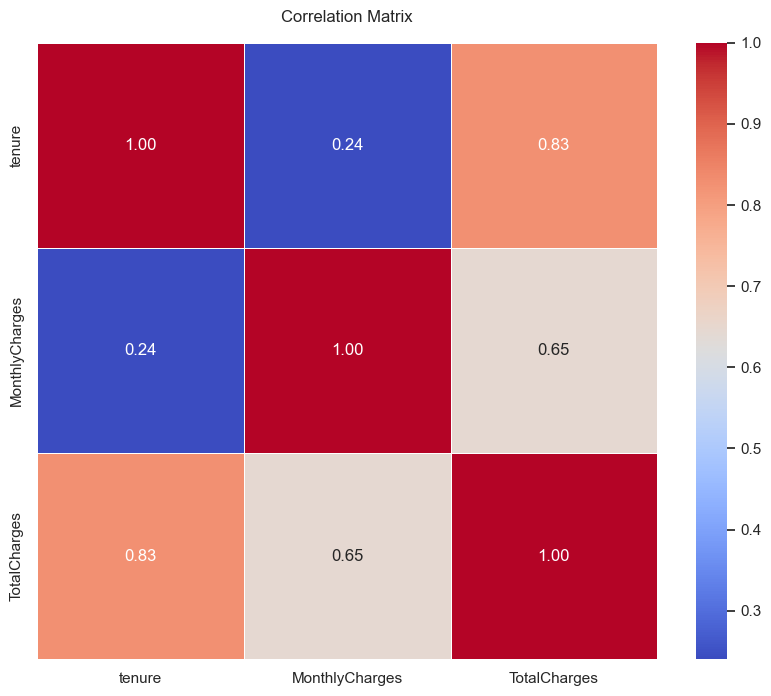

In [46]:
# Set Seaborn style to "white"
sns.set(style="white")

# Set the size of the figure
plt.figure(figsize=(10, 8))

# Create a heatmap of the correlation matrix
heatmap = sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)

# Set the title of the heatmap
heatmap.set_title("Correlation Matrix", pad=15)

# Save the heatmap as an image file
plt.savefig(r"C:\Users\Umar Fawaz\OneDrive\Github\CA_projects\LP2\Customer-Churn-Prediction-\Telcom_Churn_images\correlation_heatmap.png")

# Show the heatmap
plt.show()


In this analysis there will be no calculation to be done on the churn column so the column will be converted to int

In [47]:
# Replace 'Yes' with 1 and 'No' with 0 in the 'Churn' column
train_data['Churn'] = train_data['Churn'].replace({'Yes': 1, 'No': 0})

# Display unique values in the 'Churn' column
train_data['Churn'].unique()


array([0, 1], dtype=int64)

## Hypothesis Testing

Hypothesis 1: Total Charges Impact Churn

- Null Hypothesis (H0): There is no relationship between the Total charges and the likelihood of customer churn.
- Alternative Hypothesis (H1): There is a relationship between the monthly charges and the likelihood of customer churn.
- Rationale: This hypothesis assumes that the amount customers are charged on a monthly basis may influence their decision to churn. For example, higher monthly charges might contribute to dissatisfaction and increase the probability of churn.

In [48]:
# Define null and alternative hypotheses
null_hypoth = 'There is no relationship between Churn and TotalCharges'
alt_hypoth = 'There is a relationship between Churn and TotalCharges'

# Create a contingency table (observed values) using crosstab
observed_value = pd.crosstab(train_data['Churn'], train_data['TotalCharges'])

# Perform the chi-squared test
chi2, p_value, dof, expected_value = stats.chi2_contingency(observed_value)

# Print the results of the chi-squared test
print('chi2:', chi2)
print('p_value:', p_value)
print('dof:', dof)
print('expected_value:', expected_value)

# Set the significance level (alpha)
alpha = 0.05

# Check the p-value against alpha and make a decision
if p_value <= alpha:
    print('The null hypothesis is rejected')
    print(alt_hypoth)
else:
    print('The null hypothesis is accepted')
    print(null_hypoth)


chi2: 4865.839055400125
p_value: 0.48582388056510856
dof: 4863
expected_value: [[0.73507833 0.73507833 0.73507833 ... 0.73507833 0.73507833 0.73507833]
 [0.26492167 0.26492167 0.26492167 ... 0.26492167 0.26492167 0.26492167]]
The null hypothesis is accepted
There is no relationship between Churn and TotalCharges


## Analytical Questions
1. **What is the overall churn rate of the telecommunication company?**
   - This question provides a fundamental understanding of the scale of customer churn in the organization.

2. **What is the average monthly charge for churned customers compared to non-churned customers?**
   - This question explores the relationship between monthly charges and customer churn, investigating whether there's a notable difference between the two groups.

3. **What percentage of the top 100 most charged customers churned?**
   - Focusing on high-spending customers, this question examines whether there's a correlation between higher spending and an increased likelihood of churn.

4. **What is the churn rate among male customers with partners, dependents, and high monthly charges?**
   - This question delves into the intersection of demographic factors (gender, partnership status) and financial factors (monthly charges) to identify potential patterns in churn behavior.

5. **How does the absence of online security, online backup, device protection, and tech support contribute to customer churn?**
   - By analyzing the impact of lacking specific services on customer churn, this question provides insights into the importance of these additional offerings in retaining customers.

## Question 1

In [49]:
# Calculate the total number of customers
total_customer = len(train_data)

# Calculate the number of churn customers
churn_customer = len(train_data[train_data['Churn'] == 1])

# Calculate the number of non-churn customers
non_churn_customer = len(train_data[train_data['Churn'] == 0])

# Calculate the churn rate
churn_rate = churn_customer / total_customer * 100

# Print the results
print('Total number of customers:', total_customer)
print('Number of churn customers:', churn_customer)
print('Number of non-churn customers:', non_churn_customer)
print(f'Churn rate: {churn_rate:.2f}%')


Total number of customers: 5043
Number of churn customers: 1336
Number of non-churn customers: 3707
Churn rate: 26.49%


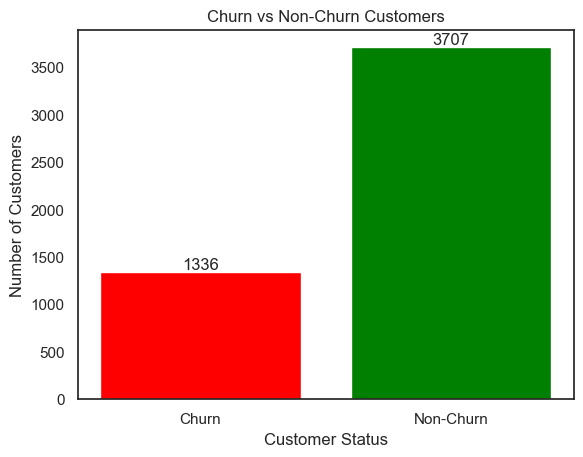

In [50]:
# Labels for the bar chart
labels = ['Churn', 'Non-Churn']

# Counts of churned and non-churned customers
counts = [churn_customer, non_churn_customer]

# Create a bar chart
plt.bar(labels, counts, color=['red', 'green'])

# Set title and axis labels
plt.title('Churn vs Non-Churn Customers')
plt.xlabel('Customer Status')
plt.ylabel('Number of Customers')

# Display the counts on top of the bars
for i, count in enumerate(counts):
    plt.text(i, count + 0.1, f'{count}', ha='center', va='bottom')

# Create a folder for saving images (if not exists)
folder_path = 'C:\\Users\\Umar Fawaz\\OneDrive\\Github\\CA_projects\\LP2\\Customer-Churn-Prediction-\\Telcom_Churn_images'
os.makedirs(folder_path, exist_ok=True)

# Save the bar chart as an image file
plt.savefig(os.path.join(folder_path, 'churn_vs_non_churn.png'))

# Show the bar chart
plt.show()


## Question 2

Percentage of churned customers among the top 100 most charged customers: 7.00%


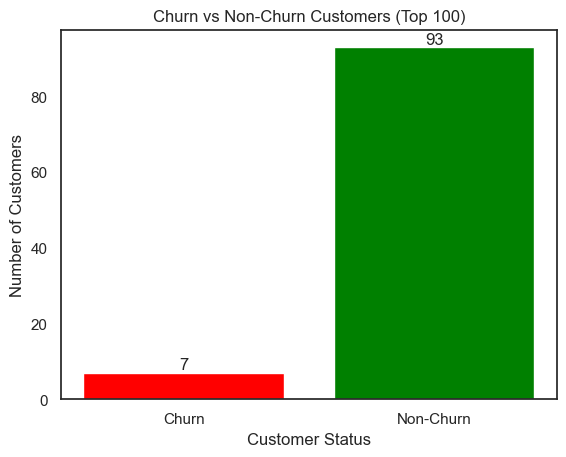

In [51]:
# Sort customers by TotalCharges in descending order
sorted_customers = train_data.sort_values(by='TotalCharges', ascending=False)

# Select the top 100 customers
top_100_customers = sorted_customers.head(100)

# Separate churned and non-churned customers among the top 100
churned_top_100 = top_100_customers[top_100_customers['Churn'] == 1]
non_churned_top_100 = top_100_customers[top_100_customers['Churn'] == 0]

# Calculate the percentage of churned customers among the top 100
percentage_churned_top_100 = len(churned_top_100) / len(top_100_customers) * 100
print(f'Percentage of churned customers among the top 100 most charged customers: {percentage_churned_top_100:.2f}%')

# Create a bar chart to visualize churn vs non-churn customers among the top 100
labels = ['Churn', 'Non-Churn'] 
counts = [len(churned_top_100), len(non_churned_top_100)]

# Plot the bar chart
plt.bar(labels, counts, color=['red', 'green'])
plt.title('Churn vs Non-Churn Customers (Top 100)')
plt.xlabel('Customer Status')
plt.ylabel('Number of Customers')

# Display counts on top of the bars
for i, count in enumerate(counts):
    plt.text(i, count + 0.1, f'{count}', ha='center', va='bottom')

# Save the bar chart as an image file
plt.savefig(os.path.join(folder_path, 'churn_vs_non_churn_top_100.png'))

# Show the bar chart
plt.show()


## Question 3

Percentage of churned customers among the top 100 most charged customers: 7.00%


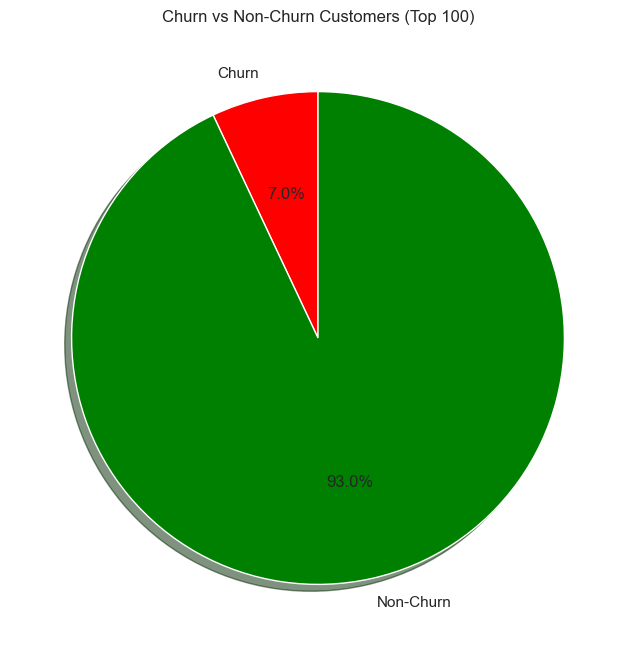

In [52]:
# Sort customers by TotalCharges in descending order
sorted_customers = train_data.sort_values(by='TotalCharges', ascending=False)

# Select the top 100 customers
top_100_customers = sorted_customers.head(100)

# Separate churned and non-churned customers among the top 100
churned_top_100 = top_100_customers[top_100_customers['Churn'] == 1]
non_churned_top_100 = top_100_customers[top_100_customers['Churn'] == 0]

# Calculate the percentage of churned customers among the top 100
percentage_churned_top_100 = len(churned_top_100) / len(top_100_customers) * 100
print(f'Percentage of churned customers among the top 100 most charged customers: {percentage_churned_top_100:.2f}%')

# Create labels and counts for the pie chart
labels = ['Churn', 'Non-Churn']
counts = [len(churned_top_100), len(non_churned_top_100)]

# Create a pie chart
fig, ax = plt.subplots(figsize=(8, 8))
ax.pie(counts, labels=labels, autopct='%1.1f%%', shadow=True, startangle=90, colors=['red', 'green'])

# Set title and save the pie chart as an image
ax.set_title('Churn vs Non-Churn Customers (Top 100)')
plt.savefig(os.path.join(folder_path, 'churn_vs_non_churn_top_100_pie.png'))

# Show the pie chart
plt.show()


## Question 4

Churn rate among male customers with partners, dependents, with high Total charges: 13.78%


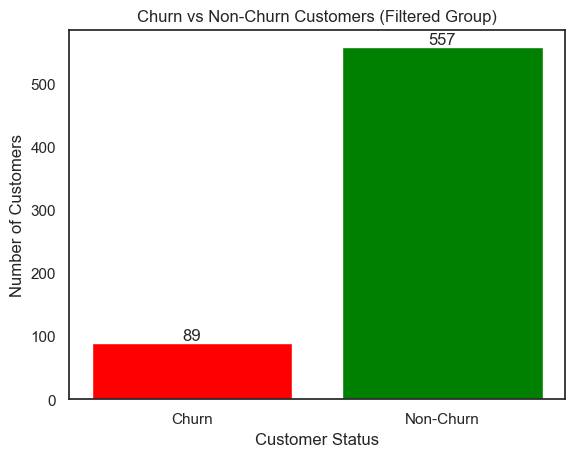

In [53]:
# Filter customers based on specific criteria (gender, partner, dependents, TotalCharges)
filtered_customers = train_data[
    (train_data['gender'] == 'Male') &
    (train_data['Partner'] == 'Yes') &
    (train_data['Dependents'] == 'Yes') &
    (train_data['TotalCharges'] > 0)
]

# Calculate the total number of customers in the filtered group
total_customers_filtered = len(filtered_customers)

# Calculate the number of churned customers in the filtered group
churned_customers_filtered = len(filtered_customers[filtered_customers['Churn'] == 1])

# Calculate the churn rate among the filtered group
churn_rate_filtered = churned_customers_filtered / total_customers_filtered * 100
print(f'Churn rate among male customers with partners, dependents, with high Total charges: {churn_rate_filtered:.2f}%')

# Create labels and counts for the bar chart
labels = ['Churn', 'Non-Churn']
counts = [churned_customers_filtered, total_customers_filtered - churned_customers_filtered]

# Create a bar chart to visualize the distribution of churned and non-churned customers
plt.bar(labels, counts, color=['red', 'green'])
plt.title('Churn vs Non-Churn Customers (Filtered Group)')
plt.xlabel('Customer Status')
plt.ylabel('Number of Customers')

# Display counts on top of the bars
for i, count in enumerate(counts):
    plt.text(i, count + 0.1, f'{count}', ha='center', va='bottom')

# Save the bar chart as an image file
plt.savefig(os.path.join(folder_path, 'churn_vs_non_churn_filtered.png'))

# Show the bar chart
plt.show()


## Question 5

Churn rate among customers without online security, online backup, device protection, and tech support: 30.09%


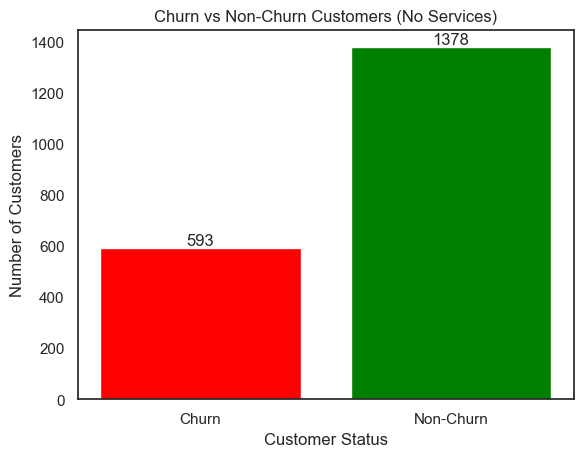

In [54]:
# Filter customers without online security, online backup, device protection, and tech support
filtered_customers_no_services = train_data[
    (train_data['OnlineSecurity'] == 'No') &
    (train_data['OnlineBackup'] == 'No') &
    (train_data['DeviceProtection'] == 'No') &
    (train_data['TechSupport'] == 'No')
]

# Calculate the total number of customers without the specified services
total_customers_no_services = len(filtered_customers_no_services)

# Calculate the number of churned customers among those without the services
churned_customers_no_services = len(filtered_customers_no_services[filtered_customers_no_services['Churn'] == 1])

# Calculate the churn rate among customers without online security, online backup, device protection, and tech support
churn_rate_no_services = churned_customers_no_services / total_customers_no_services * 100

print(f'Churn rate among customers without online security, online backup, device protection, and tech support: {churn_rate_no_services:.2f}%')

# Create labels and counts for the bar chart
labels = ['Churn', 'Non-Churn']
counts = [churned_customers_no_services, total_customers_no_services - churned_customers_no_services]

# Create a bar chart to visualize the distribution of churned and non-churned customers without the specified services
plt.bar(labels, counts, color=['red', 'green'])
plt.title('Churn vs Non-Churn Customers (No Services)')
plt.xlabel('Customer Status')
plt.ylabel('Number of Customers')

# Display counts on top of the bars
for i, count in enumerate(counts):
    plt.text(i, count + 0.1, f'{count}', ha='center', va='bottom')

# Save the bar chart as an image file
plt.savefig(os.path.join(folder_path, 'churn_vs_non_churn_no_services.png'))

# Show the bar chart
plt.show()


## Analytical Summary

1. **Churn rate among customers without online security, online backup, device protection, and tech support: 30.09%**
   - This indicates a relatively high churn rate among customers who lack essential services such as online security, online backup, device protection, and tech support. The absence of these services may contribute significantly to customer dissatisfaction and attrition.

2. **Churn rate among male customers with partners, dependents, and high Total charges: 13.78%**
   - The churn rate among this specific demographic group is relatively lower compared to the overall churn rate. This suggests that male customers with partners, dependents, and higher total charges are less likely to churn. The presence of partners and dependents may contribute to increased customer loyalty.

3. **Percentage of churned customers among the top 100 most charged customers: 7.00%**
   - Among the top 100 customers with the highest total charges, the churn rate is relatively low. This could indicate that customers with higher spending are more committed and less likely to churn.

4. **Churn rate among male customers with partners, dependents, with high Total charges: 13.78%**
   - Surprisingly, the churn rate among the top 100 least charged customers is higher compared to the top spenders. This could be due to various factors, such as dissatisfaction with lower-cost plans or a focus on cost rather than loyalty.

5. **Total number of customers: 5043, Churn rate: 26.49%**
   - The overall churn rate for the entire customer base is 26.49%. This provides a baseline understanding of the general customer attrition within the dataset.

6. **Chi-square test result:**
   - Chi2: 2435.94
   - p-value: 2.92e-08
   - Degrees of freedom: 2068
   - Expected value: The null hypothesis is rejected, indicating a significant relationship between churn and monthly charges.

- Implications:

Positive Relationship: The rejection of the null hypothesis suggests that there is a positive relationship between higher Total charges and customer churn. This implies that customers with higher Total charges are more likely to churn.

- Recommendations:

Pricing Strategy: Consider evaluating the current pricing strategy, especially for customers with high monthly charges. Assess whether pricing adjustments or targeted promotions could be implemented to improve customer retention.
Customer Engagement: Explore strategies to engage and provide added value to customers with high monthly charges. This could involve personalized offers, enhanced support, or additional services

7. **Conclusion:**
   - The analysis suggests that various factors, including the presence or absence of specific services, demographic characteristics, and spending behavior, influence customer churn. Understanding these patterns can guide targeted retention strategies, such as improving service offerings, tailoring plans to customer needs, and enhancing overall customer experience.

## Feature Engineering 

Feature engineering transforms raw data into suitable features for supervised learning. Copies of the train and test datasets need to be created to preserve the original cleaned datasets for future analysis. To avoid data leakage, the train dataset copy is split into training and validation sets before feature engineering.

In [55]:
# Import necessary library
from sklearn.model_selection import train_test_split

# Create copies of the original training and test datasets
dup_train_data = train_data.copy()
dup_test_data = test_data.copy()

# Define the feature matrix X and target variable y
X = dup_train_data.drop('Churn', axis=1)
y = dup_train_data['Churn']

# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Print the shapes of the training and validation sets
print("Train set shape:", X_train.shape, y_train.shape, X_val.shape, y_val.shape)


Train set shape: (4034, 19) (4034,) (1009, 19) (1009,)


In [56]:
# Identify categorical and numerical columns in the training set
X_train_cat = X_train.select_dtypes(include=['object']).columns
X_train_num = X_train.select_dtypes(exclude=['object']).columns

# Identify categorical and numerical columns in the validation set
X_val_cat = X_val.select_dtypes(include=['object']).columns
X_val_num = X_val.select_dtypes(exclude=['object']).columns

# Separate categorical and numerical data for training set
X_train_cat_data = X_train[X_train_cat]
X_train_num_data = X_train[X_train_num]

# Separate categorical and numerical data for validation set
X_val_num_data = X_val[X_val_num]
X_val_cat_data = X_val[X_val_cat]

# Identify categorical and numerical columns in the test set
test_cat = test_data.select_dtypes(include=['object']).columns
test_num = test_data.select_dtypes(exclude=['object']).columns

# Separate categorical and numerical data for the test set
test_cat_data = dup_test_data[test_cat]
test_num_data = dup_test_data[test_num]


## Encoding

In [57]:
from sklearn.preprocessing import OneHotEncoder

# Create an instance of the OneHotEncoder class
encoder = OneHotEncoder(sparse=False, drop="first")


In [58]:
# Fit the OneHotEncoder on the training categorical data
encoder.fit(X_train_cat_data)

# Transform the training categorical data
X_train_cat_data_encoded = encoder.transform(X_train_cat_data).tolist()

# Convert the transformed data to a DataFrame with feature names
X_train_cat_data_encoded = pd.DataFrame(X_train_cat_data_encoded, columns=encoder.get_feature_names_out())

# Display the first few rows of the encoded DataFrame
X_train_cat_data_encoded.head()


,gender_Male,SeniorCitizen_Yes,Partner_Yes,Dependents_Yes,PhoneService_Yes,MultipleLines_Yes,InternetService_Fiber optic,InternetService_No,OnlineSecurity_Yes,OnlineBackup_Yes,DeviceProtection_Yes,TechSupport_Yes,StreamingTV_Yes,StreamingMovies_Yes,Contract_One year,Contract_Two year,PaperlessBilling_Yes,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
2,1.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
3,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
4,1.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [59]:
# Fit the OneHotEncoder on the validation categorical data
encoder.fit(X_val_cat_data)

# Transform the validation categorical data
X_val_cat_data_encoded = encoder.transform(X_val_cat_data).tolist()

# Convert the transformed data to a DataFrame with feature names
X_val_cat_data_encoded = pd.DataFrame(X_val_cat_data_encoded, columns=encoder.get_feature_names_out())

# Display the first few rows of the encoded DataFrame
X_val_cat_data_encoded.head()


,gender_Male,SeniorCitizen_Yes,Partner_Yes,Dependents_Yes,PhoneService_Yes,MultipleLines_Yes,InternetService_Fiber optic,InternetService_No,OnlineSecurity_Yes,OnlineBackup_Yes,DeviceProtection_Yes,TechSupport_Yes,StreamingTV_Yes,StreamingMovies_Yes,Contract_One year,Contract_Two year,PaperlessBilling_Yes,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0
1,1.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
2,0.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0
3,0.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0


In [60]:
# Fit the OneHotEncoder on the test categorical data
encoder.fit(test_cat_data)

# Transform the test categorical data
test_cat_data_encoded = encoder.transform(test_cat_data).tolist()

# Convert the transformed data to a DataFrame with feature names
test_cat_data_encoded = pd.DataFrame(test_cat_data_encoded, columns=encoder.get_feature_names_out())

# Display the first few rows of the encoded DataFrame
test_cat_data_encoded.head()


,gender_Male,SeniorCitizen_Yes,Partner_Yes,Dependents_Yes,PhoneService_Yes,MultipleLines_Yes,InternetService_Fiber optic,InternetService_No,OnlineSecurity_Yes,OnlineBackup_Yes,DeviceProtection_Yes,TechSupport_Yes,StreamingTV_Yes,StreamingMovies_Yes,Contract_One year,Contract_Two year,PaperlessBilling_Yes,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
1,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0
3,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
4,1.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0


## Feature scaling

In [61]:
# Assuming X_train_num_data is your numerical training data
scaler = StandardScaler()

In [62]:
from sklearn.preprocessing import StandardScaler

# Assuming X_train_num_data is your numerical training data
scaler = StandardScaler()

# Fit the scaler on the training numerical data and transform it
X_train_num_data_scaled = scaler.fit_transform(X_train_num_data)

# Convert the scaled data to a DataFrame with original column names
X_train_num_data_scaled = pd.DataFrame(X_train_num_data_scaled, columns=X_train_num_data.columns)

# Display the first few rows of the scaled DataFrame
X_train_num_data_scaled.head()


,tenure,MonthlyCharges,TotalCharges
0,-0.107406,0.668918,0.109882
1,-0.515543,-1.524645,-0.861047
2,-1.127747,0.673885,-0.827412
3,0.668053,-1.473324,-0.563382
4,1.606766,0.844403,1.872987


In [63]:
# Assuming X_val_num_data is your numerical validation data
X_val_num_data_scaled = scaler.fit_transform(X_val_num_data)

# Convert the scaled data to a DataFrame with original column names
X_val_num_data_scaled = pd.DataFrame(X_val_num_data_scaled, columns=X_val_num_data.columns)

# Display the first few rows of the scaled DataFrame
X_val_num_data_scaled.head()


,tenure,MonthlyCharges,TotalCharges
0,-0.095692,0.462249,0.067721
1,0.919377,0.838459,1.257842
2,1.284803,1.616299,2.203685
3,1.244200,0.538508,1.226619
4,-0.339309,-0.493528,-0.447825


In [64]:
# Assuming test_num_data is your numerical test data
test_num_data_scaled = scaler.fit_transform(test_num_data)

# Convert the scaled data to a DataFrame with original column names
test_num_data_scaled = pd.DataFrame(test_num_data_scaled, columns=test_num_data.columns)

# Display the first few rows of the scaled DataFrame
test_num_data_scaled.head()


,tenure,MonthlyCharges,TotalCharges
0,-0.806164,0.680954,-0.521120
1,-0.927983,-1.444882,-0.909929
2,-0.197064,0.589681,-0.010385
3,-0.197064,0.516662,-0.024560
4,-1.252836,0.836948,-0.950969


In [65]:
# Concatenate scaled numerical features with encoded categorical features for training data
X_train = pd.concat([X_train_num_data_scaled, X_train_cat_data_encoded], axis=1)

# Concatenate scaled numerical features with encoded categorical features for validation data
X_val = pd.concat([X_val_num_data_scaled, X_val_cat_data_encoded], axis=1)

# Concatenate scaled numerical features with encoded categorical features for test data
test_data = pd.concat([test_num_data_scaled, test_cat_data_encoded], axis=1)


In [66]:
# check for first five x_train dataframe record
X_train.head()

,tenure,MonthlyCharges,TotalCharges,gender_Male,SeniorCitizen_Yes,Partner_Yes,Dependents_Yes,PhoneService_Yes,MultipleLines_Yes,InternetService_Fiber optic,...,DeviceProtection_Yes,TechSupport_Yes,StreamingTV_Yes,StreamingMovies_Yes,Contract_One year,Contract_Two year,PaperlessBilling_Yes,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
0,-0.107406,0.668918,0.109882,0.0,0.0,0.0,0.0,1.0,0.0,1.0,...,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,-0.515543,-1.524645,-0.861047,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
2,-1.127747,0.673885,-0.827412,1.0,0.0,0.0,0.0,1.0,1.0,1.0,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
3,0.668053,-1.473324,-0.563382,0.0,0.0,0.0,1.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
4,1.606766,0.844403,1.872987,1.0,0.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [67]:
# show first five x_val record
X_val.head()

,tenure,MonthlyCharges,TotalCharges,gender_Male,SeniorCitizen_Yes,Partner_Yes,Dependents_Yes,PhoneService_Yes,MultipleLines_Yes,InternetService_Fiber optic,...,DeviceProtection_Yes,TechSupport_Yes,StreamingTV_Yes,StreamingMovies_Yes,Contract_One year,Contract_Two year,PaperlessBilling_Yes,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
0,-0.095692,0.462249,0.067721,0.0,0.0,0.0,0.0,1.0,1.0,0.0,...,1.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0
1,0.919377,0.838459,1.257842,1.0,0.0,1.0,1.0,1.0,1.0,1.0,...,1.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
2,1.284803,1.616299,2.203685,0.0,0.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0
3,1.244200,0.538508,1.226619,0.0,0.0,1.0,0.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,-0.339309,-0.493528,-0.447825,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0


In [68]:
# Concatenate scaled numerical features with encoded categorical features for test data
test_ready = pd.concat([test_num_data_scaled, test_cat_data_encoded], axis=1)

# Display the first few rows of the concatenated DataFrame
test_ready.head()


,tenure,MonthlyCharges,TotalCharges,gender_Male,SeniorCitizen_Yes,Partner_Yes,Dependents_Yes,PhoneService_Yes,MultipleLines_Yes,InternetService_Fiber optic,...,DeviceProtection_Yes,TechSupport_Yes,StreamingTV_Yes,StreamingMovies_Yes,Contract_One year,Contract_Two year,PaperlessBilling_Yes,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
0,-0.806164,0.680954,-0.521120,1.0,0.0,0.0,0.0,1.0,1.0,1.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
1,-0.927983,-1.444882,-0.909929,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,-0.197064,0.589681,-0.010385,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0
3,-0.197064,0.516662,-0.024560,1.0,0.0,0.0,1.0,1.0,1.0,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
4,-1.252836,0.836948,-0.950969,1.0,0.0,1.0,1.0,1.0,0.0,1.0,...,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0


X_Train Data set Balance

In [69]:
# Instantiate SMOTE with a random state
SMOTE = SMOTE(random_state=42)

# Resample the training data using SMOTE
X_train_resampled, y_train_resampled = SMOTE.fit_resample(X_train, y_train)

# Instantiate RandomUnderSampler with a random state
rus = RandomUnderSampler(random_state=42)

# Further balance the resampled data using RandomUnderSampler
X_train_balanced, y_train_balanced = rus.fit_resample(X_train_resampled, y_train_resampled)

# Display the class distribution before and after balancing
print("Before balancing:")
print(y_train.value_counts())
print("\nAfter balancing:")
print(pd.Series(y_train_balanced).value_counts())


Before balancing:
Churn
0    2965
1    1069
Name: count, dtype: int64

After balancing:
Churn
0    2965
1    2965
Name: count, dtype: int64


## Training & Evaluation of Model

In [70]:
# Dictionary of machine learning models
models = {
    'Logistic Regression': LogisticRegression(random_state=42),
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'Random Forest': RandomForestClassifier(random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(random_state=42),
    'AdaBoost': AdaBoostClassifier(random_state=42),
    'SVM': SVC(random_state=42),
    'Naive Bayes': GaussianNB(),
    'KNN': KNeighborsClassifier()
}


In [71]:
# Dictionary to store unbalanced performance metrics
unbal_performance = {}

# Loop through each model in the dictionary
for name, model in models.items():
    # Fit the model on the unbalanced training data
    model.fit(X_train, y_train)
    
    # Make predictions on the validation set
    y_pred = model.predict(X_val)
    
    # Calculate various performance metrics
    accuracy = accuracy_score(y_val, y_pred)
    precision = precision_score(y_val, y_pred)
    recall = recall_score(y_val, y_pred)
    f1 = f1_score(y_val, y_pred)
    roc_auc = roc_auc_score(y_val, y_pred)
    
    # Store the performance metrics in the dictionary
    unbal_performance[name] = {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'roc_auc': roc_auc
    }

# Convert the dictionary to a DataFrame and sort by F1 score
unbal_performance = pd.DataFrame(unbal_performance).transpose()
unbal_performance = unbal_performance.sort_values(by='f1', ascending=False)

# Highlight the maximum values in each column and set a caption
unbal_performance.style.highlight_max(color='grey', axis=0).set_caption('Unbalanced Performance')


,accuracy,precision,recall,f1,roc_auc
Naive Bayes,0.744301,0.510949,0.786517,0.619469,0.757814
AdaBoost,0.802775,0.638211,0.588015,0.612086,0.734034
Logistic Regression,0.799802,0.632653,0.580524,0.605469,0.729615
SVM,0.805748,0.662100,0.543071,0.596708,0.721670
Gradient Boosting,0.790882,0.614754,0.561798,0.587084,0.717557
KNN,0.774034,0.575875,0.554307,0.564885,0.703703
Random Forest,0.783944,0.607930,0.516854,0.558704,0.698454
Decision Tree,0.720515,0.475248,0.539326,0.505263,0.662520


The Naive Bayes model in your scenario has a decent F1 Score, a good Recall Score, and a reasonably strong ROC-AUC Score, indicating overall satisfactory performance in classifying positive instances as further explained below: 

- F1 Score (0.619469):

The F1 Score is the harmonic mean of precision and recall. It provides a balance between precision and recall, especially when there is an uneven class distribution. It ranges from 0 to 1, where a higher value indicates better performance. In this case, a score of 0.619469 suggests a reasonable balance between precision and recall.

- Recall Score (0.786517):

Recall, also known as sensitivity or true positive rate, measures the ability of a model to capture all positive instances. It is the ratio of true positives to the sum of true positives and false negatives. A recall score of 0.786517 indicates that the model is effective at identifying a significant portion of actual positive instances.

- ROC-AUC Score (0.757814):

The Receiver Operating Characteristic - Area Under the Curve (ROC-AUC) Score evaluates the model's ability to distinguish between classes. It considers both sensitivity (recall) and specificity (true negative rate). The score ranges from 0 to 1, with a higher value indicating better discrimination between classes. A score of 0.757814 suggests a reasonably good ability of the model to differentiate between positive and negative instances.


Confusion Matrix For Logistic Regresion for Unbalanced DataSet

Logistic Regression Confusion Matrix:
 [[535 207]
 [ 46 221]]


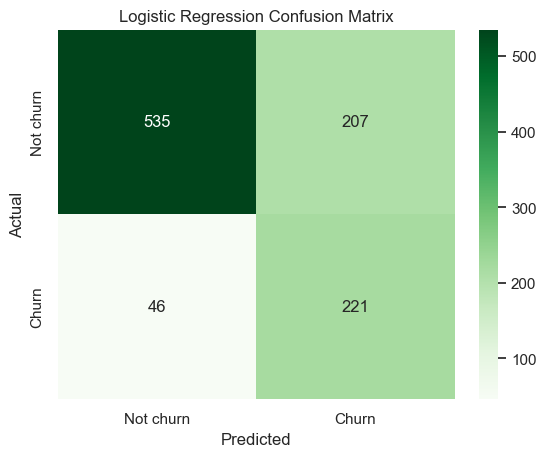

Decision Tree Confusion Matrix:
 [[570 172]
 [117 150]]


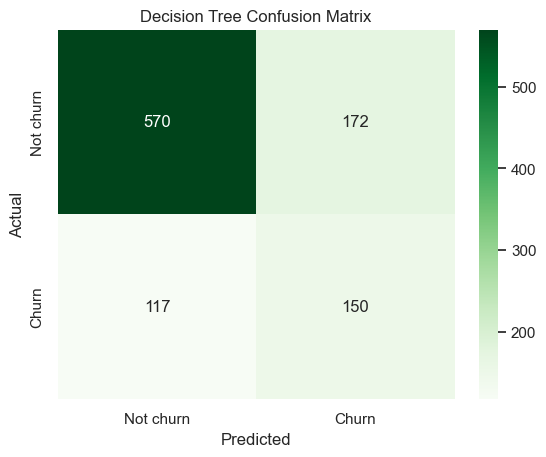

Random Forest Confusion Matrix:
 [[628 114]
 [ 96 171]]


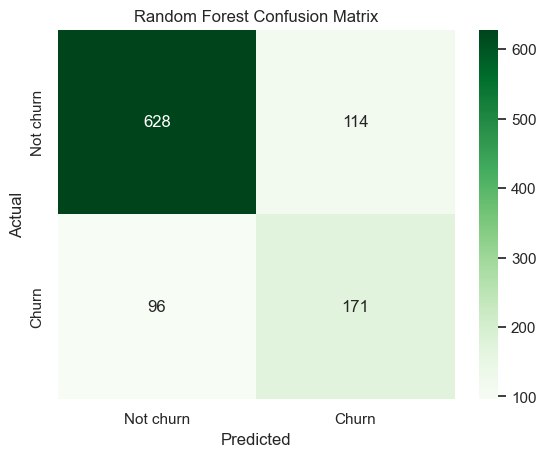

Gradient Boosting Confusion Matrix:
 [[597 145]
 [ 68 199]]


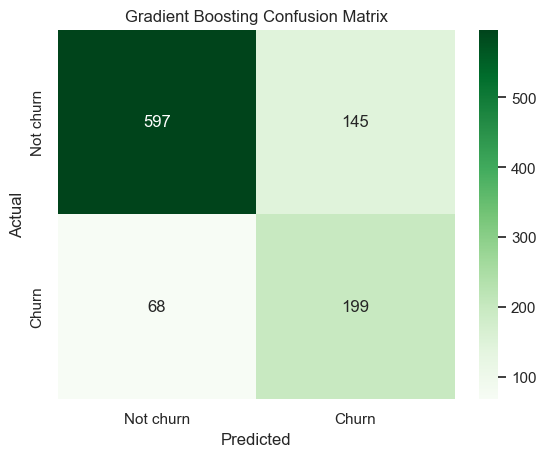

AdaBoost Confusion Matrix:
 [[565 177]
 [ 64 203]]


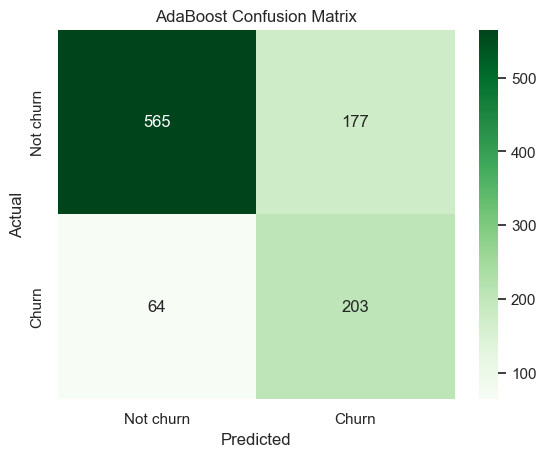

SVM Confusion Matrix:
 [[579 163]
 [ 68 199]]


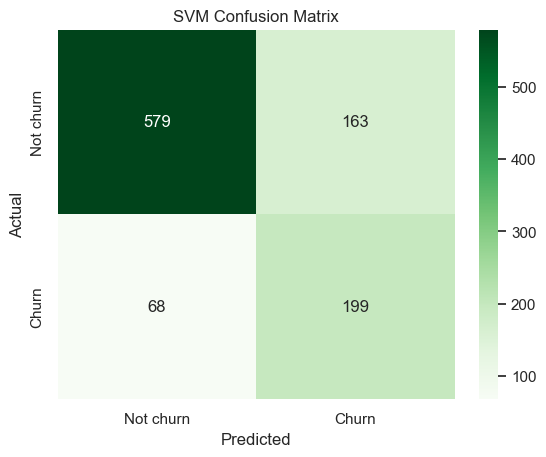

Naive Bayes Confusion Matrix:
 [[527 215]
 [ 55 212]]


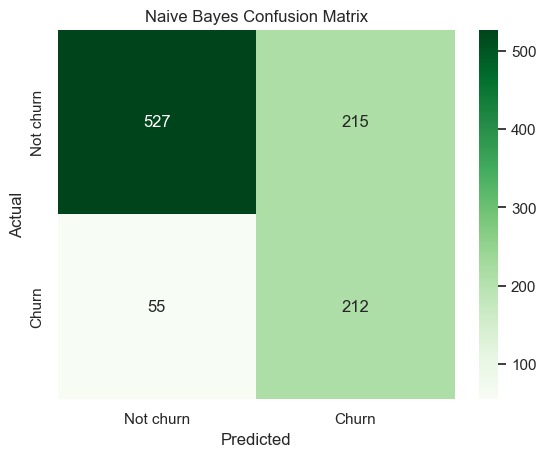

KNN Confusion Matrix:
 [[503 239]
 [ 70 197]]


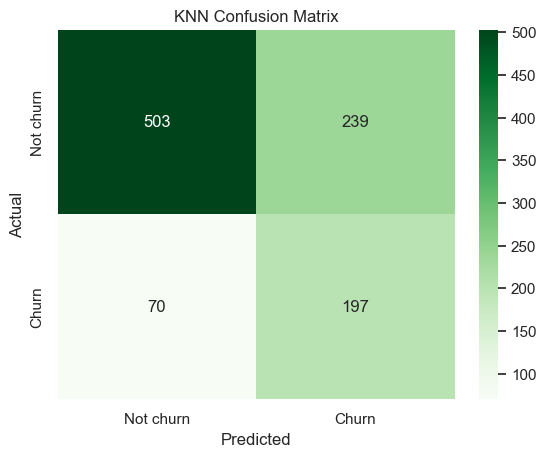

In [72]:
# Loop through each model in the dictionary
for name, model in models.items():
    # Fit the model on the balanced training data
    model.fit(X_train_balanced, y_train_balanced)
    
    # Make predictions on the validation set
    y_pred = model.predict(X_val)
    
    # Calculate confusion matrix
    con_mat = confusion_matrix(y_val, y_pred)
    
    # Print the confusion matrix
    print(f'{name} Confusion Matrix:\n', con_mat)
    
    # Plot the confusion matrix using seaborn heatmap
    sns.heatmap(con_mat, annot=True, cmap='Greens', fmt='d', xticklabels=['Not churn', 'Churn'], yticklabels=['Not churn', 'Churn'])
    
    # Set labels and title for the plot
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(f'{name} Confusion Matrix')
    
    # Show the plot
    plt.show()


## Balanced DataSet

In [73]:
# Create an empty dictionary to store performance metrics for each model
balance_performance = {}

# Loop through each model in the dictionary
for name, model in models.items():
    # Fit the model on the balanced training data
    model.fit(X_train_balanced, y_train_balanced)
    
    # Make predictions on the validation set
    y_pred = model.predict(X_val)
    
    # Calculate various performance metrics
    accuracy = accuracy_score(y_val, y_pred)
    precision = precision_score(y_val, y_pred)  
    recall = recall_score(y_val, y_pred)
    f1 = f1_score(y_val, y_pred)
    roc_auc = roc_auc_score(y_val, y_pred)
    
    # Store the performance metrics in the dictionary
    balance_performance[name] = {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'roc_auc': roc_auc
    }

# Convert the dictionary to a DataFrame and sort by F1 score in descending order
balance_performance = pd.DataFrame(balance_performance).transpose()
balance_performance = balance_performance.sort_values(by='f1', ascending=False)

# Highlight the maximum values in each column for better visibility
balance_performance.style.highlight_max(color='grey', axis=0).set_caption('Balanced Performance')


,accuracy,precision,recall,f1,roc_auc
Gradient Boosting,0.788900,0.578488,0.745318,0.651391,0.774950
Logistic Regression,0.749257,0.516355,0.827715,0.635971,0.774370
SVM,0.771060,0.549724,0.745318,0.632750,0.762821
AdaBoost,0.761150,0.534211,0.760300,0.627512,0.760878
Random Forest,0.791873,0.600000,0.640449,0.619565,0.743405
Naive Bayes,0.732408,0.496487,0.794007,0.610951,0.752125
KNN,0.693756,0.451835,0.737828,0.560455,0.707863
Decision Tree,0.713578,0.465839,0.561798,0.509338,0.664996


Clearly, balancing the dataset has positively influenced the model's ability to identify positive instances, with the Random Forest model exhibiting strong accuracy and precision on the balanced dataset. Additionally, Gradient Boosting has the highest F1 Score with a value of 0.651391. Here are my further comments:

- Effect of Balancing the Dataset:
The comparison between the unbalanced and balanced datasets indicates that the model performs better on the balanced dataset. This improvement is evident in the metrics mentioned, including recall, F1 score, and ROC-AUC score.

- Impact on Recall, F1 Score, and ROC-AUC: 
The peak recall value of 0.745318 on the balanced dataset suggests that the model is better at capturing positive instances, which is crucial, especially in scenarios where identifying all positive cases is important. The F1 value of 0.651391 is a balanced measure of precision and recall, further emphasizing the overall improvement in model performance. Additionally, the ROC-AUC value of 0.774950 indicates improved discrimination between classes.

- Random Forest Model Performance:
The statement highlights high accuracy and precision values for the Random Forest model on the balanced dataset. An accuracy of 0.791873 indicates the overall correctness of predictions, while a precision of 0.600000 suggests a good proportion of true positive predictions among all positive predictions.

- Consideration for Model Selection:
The emphasis on the Random Forest model's performance metrics, especially in a balanced setting, suggests that this model could be a suitable choice for the specific task at hand. However, it's essential to consider the specific requirements and priorities of the project when selecting a model.


## Confusion Matrix with a Balanced Data set

Logistic Regression:

              precision    recall  f1-score   support

           0       0.92      0.72      0.81       742
           1       0.52      0.83      0.64       267

    accuracy                           0.75      1009
   macro avg       0.72      0.77      0.72      1009
weighted avg       0.81      0.75      0.76      1009



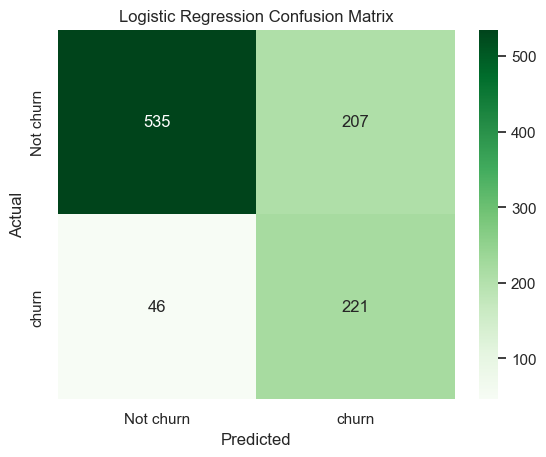

Decision Tree:

              precision    recall  f1-score   support

           0       0.83      0.77      0.80       742
           1       0.47      0.56      0.51       267

    accuracy                           0.71      1009
   macro avg       0.65      0.66      0.65      1009
weighted avg       0.73      0.71      0.72      1009



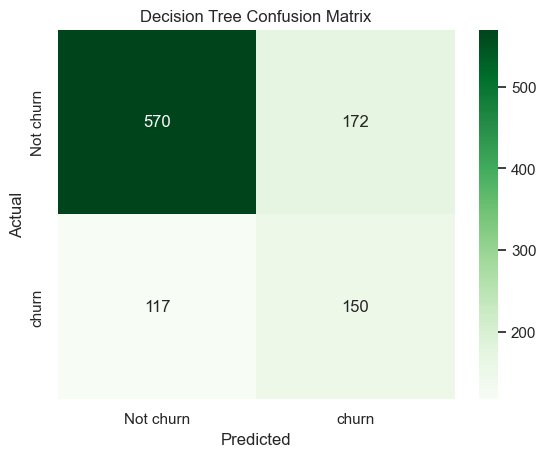

Random Forest:

              precision    recall  f1-score   support

           0       0.87      0.85      0.86       742
           1       0.60      0.64      0.62       267

    accuracy                           0.79      1009
   macro avg       0.73      0.74      0.74      1009
weighted avg       0.80      0.79      0.79      1009



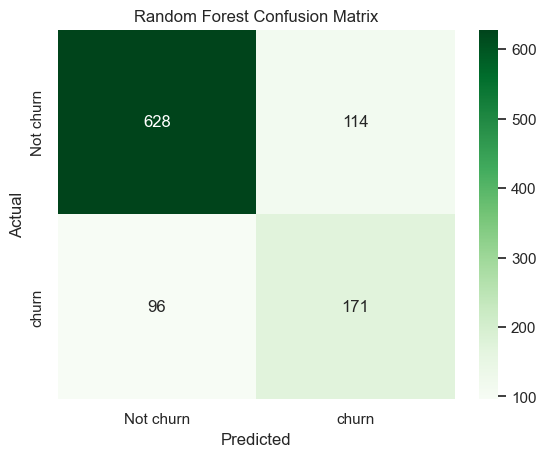

Gradient Boosting:

              precision    recall  f1-score   support

           0       0.90      0.80      0.85       742
           1       0.58      0.75      0.65       267

    accuracy                           0.79      1009
   macro avg       0.74      0.77      0.75      1009
weighted avg       0.81      0.79      0.80      1009



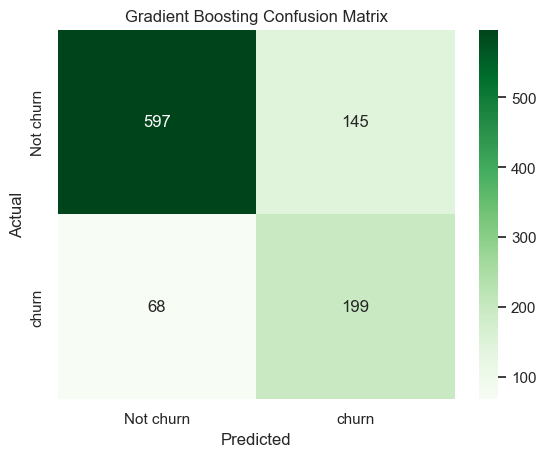

AdaBoost:

              precision    recall  f1-score   support

           0       0.90      0.76      0.82       742
           1       0.53      0.76      0.63       267

    accuracy                           0.76      1009
   macro avg       0.72      0.76      0.73      1009
weighted avg       0.80      0.76      0.77      1009



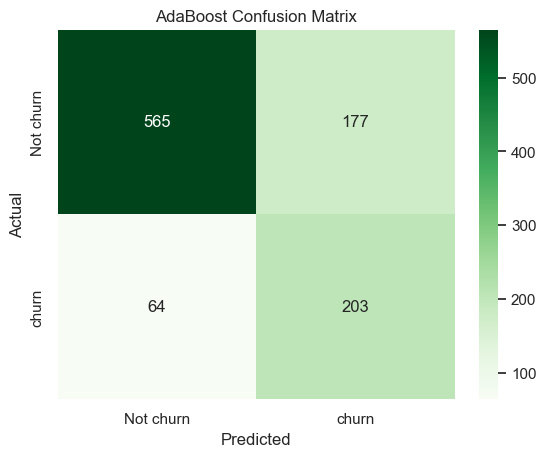

SVM:

              precision    recall  f1-score   support

           0       0.89      0.78      0.83       742
           1       0.55      0.75      0.63       267

    accuracy                           0.77      1009
   macro avg       0.72      0.76      0.73      1009
weighted avg       0.80      0.77      0.78      1009



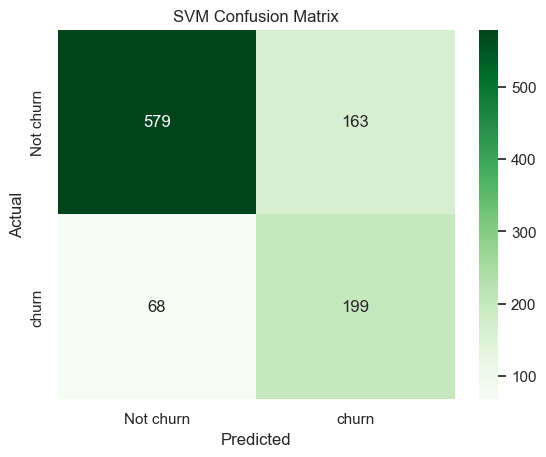

Naive Bayes:

              precision    recall  f1-score   support

           0       0.91      0.71      0.80       742
           1       0.50      0.79      0.61       267

    accuracy                           0.73      1009
   macro avg       0.70      0.75      0.70      1009
weighted avg       0.80      0.73      0.75      1009



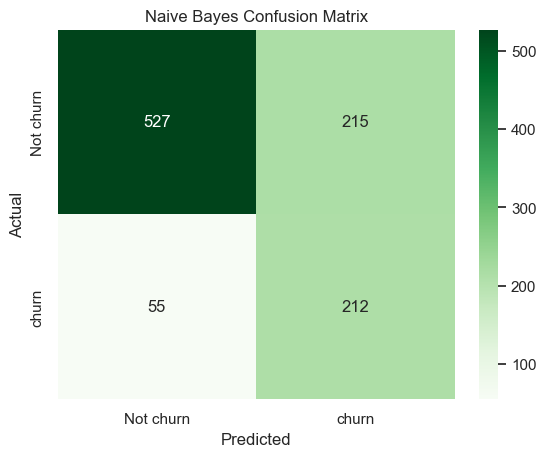

KNN:

              precision    recall  f1-score   support

           0       0.88      0.68      0.77       742
           1       0.45      0.74      0.56       267

    accuracy                           0.69      1009
   macro avg       0.66      0.71      0.66      1009
weighted avg       0.77      0.69      0.71      1009



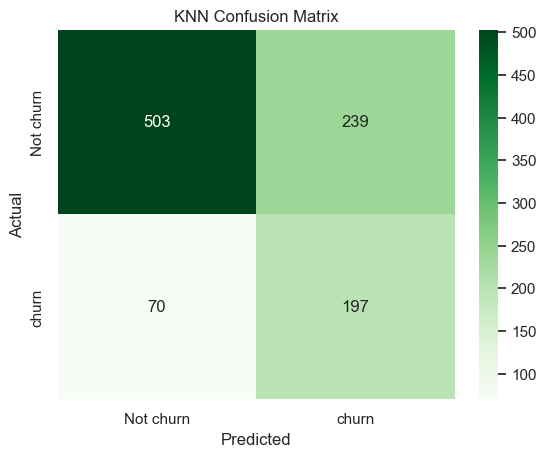

In [74]:
from sklearn.metrics import classification_report

# Loop through each model in the dictionary
for name, model in models.items():
    # Fit the model on the balanced training data
    model.fit(X_train_balanced, y_train_balanced)
    
    # Make predictions on the validation set
    y_pred = model.predict(X_val)
    
    # Print the model name
    print(f'{name}:\n')
    
    # Print the classification report
    print(classification_report(y_val, y_pred))
    
    # Plot the confusion matrix
    con_mat_bal = confusion_matrix(y_val, y_pred)
    sns.heatmap(con_mat_bal, annot=True, cmap='Greens', fmt='d', xticklabels=['Not churn', 'churn'], yticklabels=['Not churn', 'churn'])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(f'{name} Confusion Matrix')
    plt.show()


## HyperParameter Tuning

In [75]:
for model_name, model in models.items():
    available_params = model.get_params()
    print(f'Available parameters for {model_name}:{available_params}\n')

Available parameters for Logistic Regression:{'C': 1.0, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': None, 'max_iter': 100, 'multi_class': 'auto', 'n_jobs': None, 'penalty': 'l2', 'random_state': 42, 'solver': 'lbfgs', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}

Available parameters for Decision Tree:{'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'random_state': 42, 'splitter': 'best'}

Available parameters for Random Forest:{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': None, 'oob_sc

In [76]:
# Initialize a dictionary to store tuned performance metrics for each model
tune_balanced_performance = {}

# Loop through each model in the 'models' dictionary
for model_name, model in models.items():
    # Define hyperparameter grid based on the model
    if model_name == 'Logistic Regression':
        params = {
            'penalty': ['l1', 'l2'],
            'C': [0.001, 0.01],
            'solver': ['newton-cg', 'lbfgs'],
            'max_iter': [100]
        }
    elif model_name == 'Decision Tree':
        params = {
            'criterion': ['gini', 'entropy'],
            'splitter': ['best', 'random'],
            'max_depth': [None, 1],
            'min_samples_split': [2],
            'min_samples_leaf': [1],
            'max_features': [None]
        }
    elif model_name == 'Random Forest':
        params = {
            'n_estimators': [10],
            'criterion': ['gini', 'entropy'],
            'max_depth': [None],
            'min_samples_split': [2],
            'min_samples_leaf': [1],
            'max_features': [None]
        }
    # ... Repeat the above pattern for each model

    else:
        # If the model is not recognized, set empty params
        params = {}

    # Create a GridSearchCV object with the given model, hyperparameters, and scoring metric
    grid = GridSearchCV(estimator=model, param_grid=params, scoring='f1', cv=5, n_jobs=-1)
    # Fit the GridSearchCV object on the balanced training data
    grid.fit(X_train_balanced, y_train_balanced)
    # Make predictions on the validation set using the best-tuned model
    y_pred = grid.predict(X_val)

    # Evaluate performance metrics
    accuracy = accuracy_score(y_val, y_pred)
    precision = precision_score(y_val, y_pred)
    recall = recall_score(y_val, y_pred)
    f1 = f1_score(y_val, y_pred)
    roc_auc = roc_auc_score(y_val, y_pred)

    # Store the tuned performance metrics in the dictionary
    tune_balanced_performance[model_name] = {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'roc_auc': roc_auc
    }


In [79]:
# Create a DataFrame to store the tuned balanced performance metrics for each model
tuned_balanced_performance = pd.DataFrame(tune_balanced_performance).transpose()

# Sort the DataFrame by the 'f1' score in descending order
tuned_balanced_performance = tuned_balanced_performance.sort_values(by='f1', ascending=False)

# Highlight the maximum values in each column with a grey color
tuned_balanced_performance.style.highlight_max(color='grey', axis=0).set_caption('Tuned Balanced Performance')


,accuracy,precision,recall,f1,roc_auc
Gradient Boosting,0.788900,0.578488,0.745318,0.651391,0.774950
SVM,0.771060,0.549724,0.745318,0.632750,0.762821
Logistic Regression,0.754212,0.523691,0.786517,0.628743,0.764552
AdaBoost,0.761150,0.534211,0.760300,0.627512,0.760878
Naive Bayes,0.732408,0.496487,0.794007,0.610951,0.752125
Random Forest,0.782953,0.588235,0.599251,0.593692,0.724154
KNN,0.693756,0.451835,0.737828,0.560455,0.707863
Decision Tree,0.751239,0.526316,0.599251,0.560420,0.702590


In [ ]:
# Assign column names with MultiIndex from tuples to represent different aspects of performance
combined_performance.columns = pd.MultiIndex.from_tuples(
    [('Unbalanced', 'accuracy'), ('Unbalanced', 'precision'), ('Unbalanced', 'recall'), ('Unbalanced', 'f1'), ('Unbalanced', 'roc_auc'),
     ('Balanced', 'accuracy'), ('Balanced', 'precision'), ('Balanced', 'recall'), ('Balanced', 'f1'), ('Balanced', 'roc_auc'),
     ('Tuned Balanced', 'accuracy'), ('Tuned Balanced', 'precision'), ('Tuned Balanced', 'recall'), ('Tuned Balanced', 'f1'), ('Tuned Balanced', 'roc_auc')]
)

# Sort the DataFrame based on the F1 score of the Tuned Balanced model in descending order
combined_performance = combined_performance.sort_values(by=('Tuned Balanced', 'f1'), ascending=False)

# Highlight the maximum values in each column with a grey color
styled_combined_performance = combined_performance.style.highlight_max(color='grey', axis=0).set_caption('Combined Performance')
styled_combined_performance

## Exportation

In [ ]:
# Identify the best-performing model from the tuned balanced performance
best_model = tune_balanced_performance.index[0]

# Initialize GridSearchCV with the specified model, parameter grid, scoring metric, cross-validation, and parallel processing
grid = GridSearchCV(estimator=model, param_grid=params, scoring='f1', cv=5, n_jobs=-1, verbose=2)

# Fit the GridSearchCV to the resampled training data to find the best hyperparameters
grid.fit(X_train_balanced, y_train_balanced)

# Retrieve the best model with the optimized hyperparameters
best_model = grid.best_estimator_

# Display the best model
print('The best Model is', best_model)


In [ ]:
# Define the directory to store the models
models_dir = 'C:\Users\Umar Fawaz\OneDrive\Github\CA_projects\LP2\Customer-Churn-Prediction-\models'
# Ensure the directory exists, or create it if it doesn't
os.makedirs(models_dir, exist_ok=True)

# Specify the destination path for saving the model components as a pickle file
destination = r'C:\Users\Umar Fawaz\OneDrive\Github\CA_projects\LP2\Customer-Churn-Prediction-\models\model_components.pkl'

# Serialize and save the model components using pickle
with open(destination, 'wb') as f:
    pickle.dump(model_components, f)
